<a href="https://colab.research.google.com/github/Tahimi/convectionDiffusion/blob/main/lagoAdvectionDiffusionSource2D_FipyFiniteVolume2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install fipy Gmsh
# uncomment to install fipy, restart (runtime env.) and execute all

In [2]:
# authorize Colab to access and mount the Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import numpy as np
from fipy import *

In [4]:
# space discretization
geoFileName = '/content/drive/MyDrive/UFAL/advection_diffusion/FiniteDiference_FipyFiniteVolume/lagoGeoFileForGmsh.geo.txt'
cl = 30. # (m)
mesh = Gmsh2D(geoFileName)
xL, xR = min(mesh.x), max(mesh.x)
yL, yR = min(mesh.y), max(mesh.y)
delX, delY = round(xR-xL,0), round(yR-yL,0)
print('caracteristic length, cl (m) = ', cl, '\n'
      'delX (m) = ', delX, '\n'
      'delY (m) = ', delY, '\n'
      'cellsNbr = ', mesh.globalNumberOfCells)

caracteristic length, cl (m) =  30.0 
delX (m) =  2137.0 
delY (m) =  1103.0 
cellsNbr =  6377


In [5]:
# time discretization
# simulation time
delT = 200. # (h)
# advection
Cr = 0.8 # Courant Number: Cr = u*dt/dx
vx, vy = 0.0931*1e3, -0.0386*1e3 # (m/h)
dtAdv = Cr*cl/max(abs(vx),abs(vy))
# diffusion
Fr = 0.5 # Fourier Number: Fr = D*dt/dx**2
D = (delX*delY)/delT # (m**2/h)
dtDiff = abs(Fr*cl**2/D)
# advectionDiffusion
dt = dtAdv #min(dtAdv,dtDiff)

In [6]:
from datetime import timedelta

def timeSTR(hours):
    seconds = int(hours*3600)
    return str(timedelta(seconds=seconds))

print('dtAdv = ', timeSTR(dtAdv), '\n'
      'dtDiff = ', timeSTR(dtDiff), '\n'
      'dt = dtAdv = ', timeSTR(dt), '\n'
      'delT = ', timeSTR(delT))

dtAdv =  0:15:28 
dtDiff =  0:02:17 
dt = dtAdv =  0:15:28 
delT =  8 days, 8:00:00


In [7]:
# number of time steps
stepsNbr = int(delT/dt)
print('stepsNbr = int(delT/dt) = ', stepsNbr)

stepsNbr = int(delT/dt) =  775


In [8]:
# the source center is the center of the grid cell the closest
# to the given source position
def sourceCenter(sourcePos):
    global mesh
    x, y = mesh.x, mesh.y
    xs1, ys1 = sourcePos
    dist2Source = DistanceVariable(mesh=mesh,
                                   value=numerix.sqrt((x-xs1)**2+(y-ys1)**2))
    sourceClosestCellMask = (dist2Source == dist2Source.min())
    xcs, *_ = x[sourceClosestCellMask]
    ycs, *_ = y[sourceClosestCellMask]
    return (xcs, ycs)

In [9]:
# the source mask is the selection of all the grid cells in the vinicity
# of the source center, (boolean selection of mesh elements in fipy)
def sourceMask(xcs, ycs, isPonctual=True, width=0., isRectangular=False):
    global mesh
    x, y = mesh.x, mesh.y
    ds = DistanceVariable(mesh=mesh,
                          value=numerix.sqrt((x-xcs)**2+(y-ycs)**2))

    # the source is ponctual (the source is composed of only one grid cell)
    if isPonctual:
        sourceClosestCellMask = (ds == ds.min())
        return sourceClosestCellMask

    # the source shape is rectangular
    if isRectangular:
        return ((xcs-width<x) & (x<xcs+width) \
              & (ycs-width<y) & (y<ycs+width))

    # the source shape is circular
    else:
        return (ds <= width)

In [10]:
# initialization
s1Pos = (1500, 200)
s1Width = cl
zMin, s1Value = 0., 1.
sigmma = 0.25*1e-8 # (1/h)

def initialize():
    # preparing the SourceTerm
    global s1Pos, s1Width, s1Value
    xcs1, ycs1 = sourceCenter(sourcePos=s1Pos)
    s1Mask = sourceMask(xcs=xcs1,
                        ycs=ycs1,
                        isPonctual=True,
                        width=s1Width,
                        isRectangular=False)

    # unkown's initialization
    global mesh, zMin, zInit, z
    zInit = CellVariable(mesh=mesh, value=zMin)
    zInit.setValue(s1Value, where=s1Mask)
    z = CellVariable(mesh=mesh, value=zInit)

    # Applying noFlow BC
    z.faceGrad.constrain((0.,), where=mesh.exteriorFaces)

    # Defining the discritized equation
    global vx, vy, D, sigmma, eq
    eq = (TransientTerm(coeff=1.0)
       + PowerLawConvectionTerm(coeff=(vx,vy))
       == DiffusionTerm(coeff=D)
       + ImplicitSourceTerm(coeff=-sigmma)
       - ImplicitSourceTerm(s1Mask * 1e+10) + s1Mask * 1e+10 * s1Value)

# initialize the discritized model
initialize()

Initial distribution


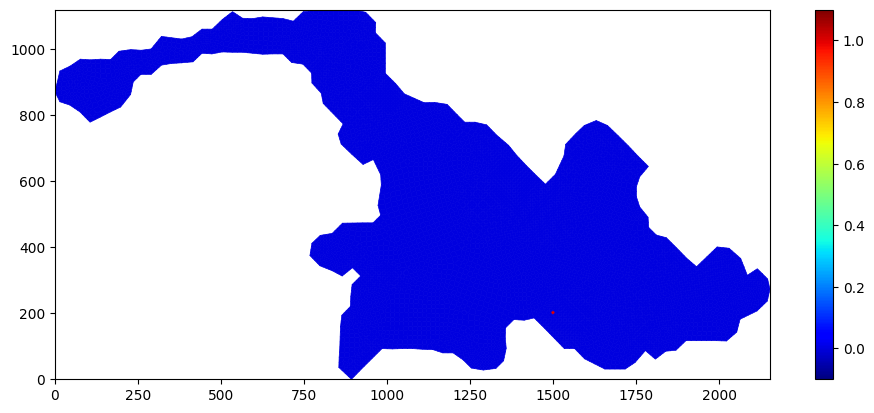

In [11]:
# ploting the unkown's initial distribution
print('Initial distribution')
viewer = Viewer(vars = (zInit),
                datamin = zInit.min()-.1,
                datamax = zInit.max()+.1)
viewer.plotMesh()

In [12]:
# defining the time-step update function
def advectAndDiffuse1(z, dt):
    eq.solve(var=z, dt=dt)

In [17]:
# display some parameters
print('caracteristic length, cl (m) = ', cl, '\n'
      'delX (m) = ', delX, '\n'
      'delY (m) = ', delY, '\n'
      'cellsNbr = ', mesh.globalNumberOfCells, '\n'
      'vx (m/h) = ', round(vx,1), '\n'
      'vy (m/h) = ', round(vy,1), '\n'
      'Cr (-) = ', Cr, '\n'
      'dtAdv = ', timeSTR(dtAdv), '\n'
      'D (m**2/h) = ', D, '\n'
      'Fr (-) = ', Fr, '\n'
      'dtDiff = ', timeSTR(dtDiff), '\n'
      'dt = ', timeSTR(dt), '\n'
      'delT = ', timeSTR(delT), '\n'
      'int(delT/dt) = ', int(delT/dt), '\n'
      'stepsNbr = ', stepsNbr, '\n'
      'delT_sim = ', timeSTR(dt*stepsNbr))

caracteristic length, cl (m) =  30.0 
delX (m) =  2137.0 
delY (m) =  1103.0 
cellsNbr =  6377 
vx (m/h) =  93.1 
vy (m/h) =  -38.6 
Cr (-) =  0.8 
dtAdv =  0:15:28 
D (m**2/h) =  11785.555 
Fr (-) =  0.5 
dtDiff =  0:02:17 
dt =  0:15:28 
delT =  8 days, 8:00:00 
int(delT/dt) =  775 
stepsNbr =  775 
delT_sim =  8 days, 7:47:06


In [14]:
# iterate in time
for step in range(stepsNbr):
    advectAndDiffuse1(z, dt)

Distribution after 8 days, 7:47:06


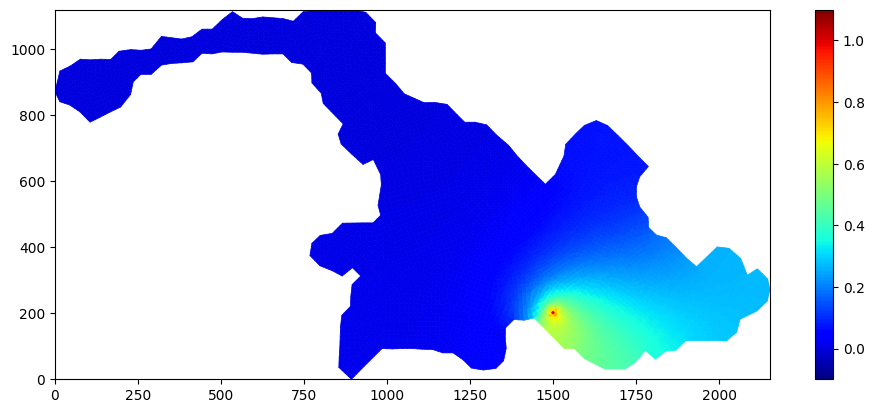

In [15]:
# ploting the unkown's final distribution
print('Distribution after', timeSTR(dt*stepsNbr))
viewer = Viewer(vars = (z),
                datamin = z.min()-.1,
                datamax = z.max()+.1)
viewer.plot()